In [1]:
import os
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import earthpy as et
import imageio
from datetime import datetime

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import cv2
from matplotlib.colors import hsv_to_rgb

(10000, 10000, 3) uint8


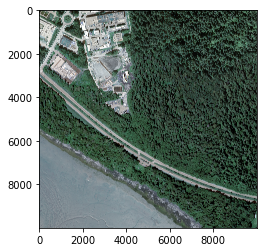

In [2]:
os.chdir(os.path.join(et.io.HOME, "ubc/capstone/orthophoto/2014"))
image = cv2.imread('483E_5454N.tif')
type(image)
print(image.shape, image.dtype)
plt.imshow(image)
nemo = image[:5000, :5000, :]
hsv_nemo = cv2.cvtColor(nemo[:5000,:5000,:], cv2.COLOR_RGB2HSV)

In [ ]:
nemo = image[:5000, :5000, :]
r, g, b = cv2.split(nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
pixel_colors = nemo.reshape((np.shape(nemo)[0]*np.shape(nemo)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()
axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()


NameError: name 'pixel_colors' is not defined

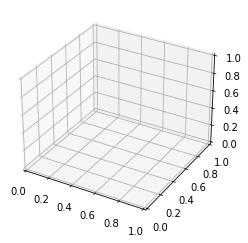

In [37]:
hsv_nemo = cv2.cvtColor(nemo[:5000,:5000,:], cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker="x")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()


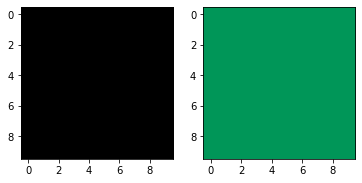

In [7]:
dark_green = (50,0, 0)
light_green = (110, 255, 150)
lo_square = np.full((10, 10, 3), light_green, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_green, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

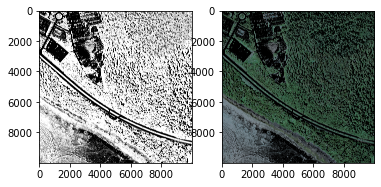

0:00:05.592859


In [8]:
startTime = datetime.now()
nemo = image
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv_nemo, dark_green, light_green)
result = cv2.bitwise_and(nemo, nemo, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()
print(datetime.now() - startTime)

std dev
original: 57.35351437448707
blurred, sigma = 2: 52.826524445702105
blurred, sigma = 4: 51.33009473092638
blurred, sigma = 6: 50.4315186119579
blurred, sigma = 8: 49.704755769160414


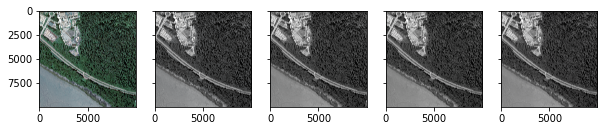

In [11]:
def blur_image_plot(image, n):
    fig, ax = plt.subplots(1, n+1, figsize=(10, 10), sharex=True, sharey=True)
    print("std dev\n=======\noriginal: {}".format(image.std()))
    ax[0].imshow(image)
    for i in range(1,n+1):
        blurred_image = ndimage.gaussian_filter(image, sigma=2*i)
        print("blurred, sigma = {}: {}".format(2*i, blurred_image.std()))
        ax[i].imshow(blurred_image)
blur_image_plot(nemo,4)

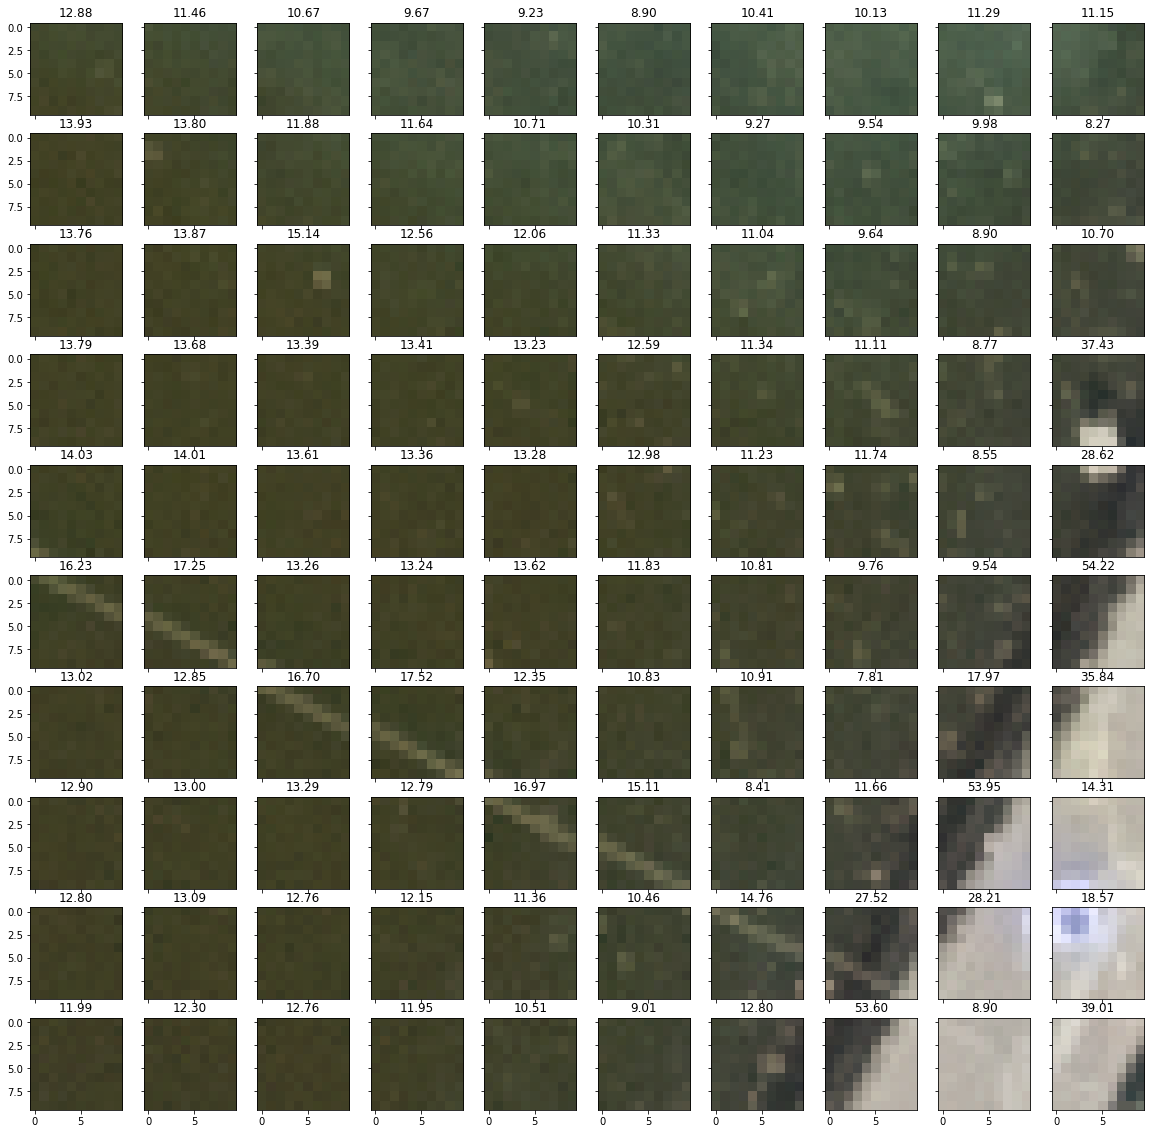

In [13]:
def plot_window_stddev(n, window_size, offset,im):
    fig, ax = plt.subplots(n, n, figsize=(20,20), sharex=True, sharey=True)

    for y in range(offset,n+offset):
        for x in range(offset,n+offset):
            r = im[y*window_size:(y+1)*window_size, x*window_size:(x+1)*window_size, 0:3]
            ax[y-offset,x-offset].imshow(r)
            ax[y-offset,x-offset].set_title("{:.2f}".format(r.std()))
plot_window_stddev(10,10,0,nemo)

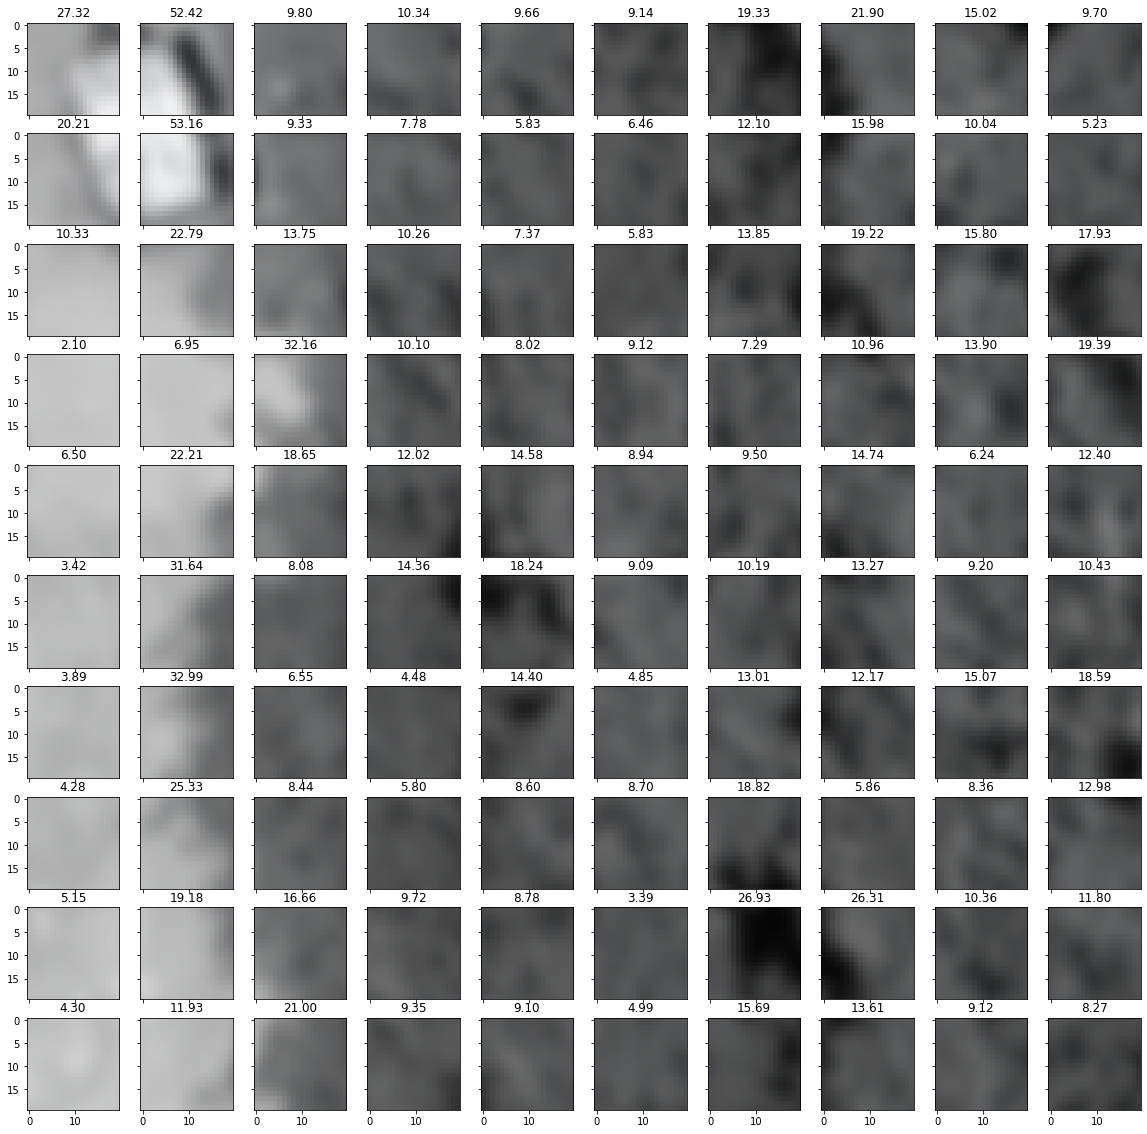

In [24]:
blurred_image = ndimage.gaussian_filter(nemo, sigma=2)
plot_window_stddev(10,20,200,blurred_image)

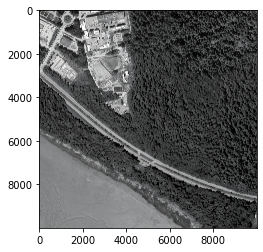

In [20]:
blurred_image = ndimage.gaussian_filter(nemo, sigma=2)
plt.imshow(blurred_image, cmap=plt.cm.gray)

In [32]:
def stddev_above_threshold(x,y,window_size, threshold,im):
    r = im[x*window_size:(x+1)*window_size, y*window_size:(y+1)*window_size, 0:3]
    return r.std() > threshold

0:00:08.182617


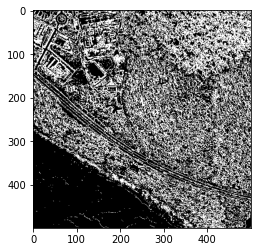

In [35]:
n = 500
startTime = datetime.now()
stddev_array = np.array([stddev_above_threshold(i//n,i%n,20,15,blurred_image) for i in range(0,n**2)]).reshape(n,n)
print(datetime.now() - startTime)
plt.imshow(stddev_array, cmap=plt.cm.gray)

0:15:03.837117


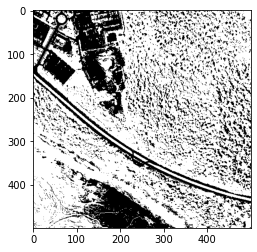

In [50]:
def compressed_green(x,y,window_size,green_mask):
    r = green_mask[x*window_size:(x+1)*window_size, y*window_size:(y+1)*window_size]
    return r.mean() > 128
n = 500
compressed_green_array = np.array([compressed_green(i//n,i%n,20,mask) for i in range(0,n**2)]).reshape(n,n)
plt.imshow(compressed_green_array, cmap=plt.cm.gray)
print(datetime.now() - startTime)

In [51]:
print(compressed_green_array)

[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True False]
 [ True  True  True ... False False False]]


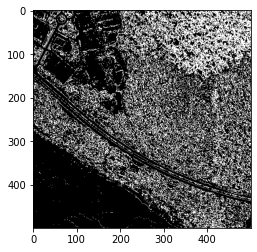

In [52]:
n=500
green_stddev_array = np.array([compressed_green_array[i//n,i%n] and stddev_array[i//n,i%n] for i in range(0,n**2)]).reshape(n,n)
plt.imsave("green_stddev.png", green_stddev_array)
plt.imshow(green_stddev_array,cmap=plt.cm.gray)

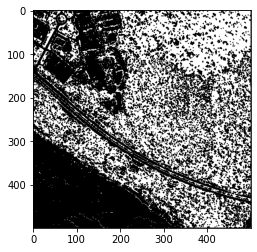

In [53]:
close_img = ndimage.binary_closing(green_stddev_array)
plt.imshow(close_img, cmap=plt.cm.gray)

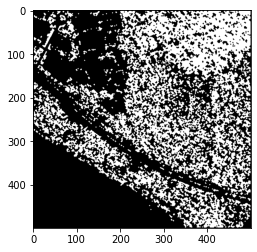

In [54]:
open_img = ndimage.binary_opening(close_img)
plt.imshow(open_img, cmap=plt.cm.gray)